# Import

In [124]:
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdDepictor, rdMolDescriptors

from IPython.core.display import display, HTML

import pandas as pd

import matplotlib.pyplot as plt

import mols2grid

import time
rdDepictor.SetPreferCoordGen(True)

import rdkit
%pylab inline
print(rdkit.__version__)

cmap = plt.get_cmap("tab10")


Populating the interactive namespace from numpy and matplotlib
2020.09.1


### Substructure alerts

In [45]:
furan = Chem.MolFromSmarts('[o]1[c][c][c][c]1')
thiophene = Chem.MolFromSmarts('[s]1[c][c][c][c]1')
thiol = Chem.MolFromSmarts('[S][#1]')
phenol = Chem.MolFromSmarts('[c]1[c][c][c][c][c]1[O][#1]')
nitro = Chem.MolFromSmarts('[c][$([NX3](=O)=O),$([NX3+](=O)[O-])]')

boronic_acid = Chem.MolFromSmarts('B') # just remove boron-containing compounds
sulphonic_acid = Chem.MolFromSmarts('S(-O)-O')  # TODO proper smarts

alert_substructs = \
    [furan,
     thiophene,
     thiol,
     phenol,
     nitro,
     boronic_acid,
     sulphonic_acid
    ]

def search_alerts(mol, alert_substructs=alert_substructs):
    for substruct in alert_substructs:
        if Chem.AddHs(mol).HasSubstructMatch(substruct):
            return True
    else:
        return False


In [118]:
data_dir = '/rds-d7/project/rds-ZNFRY9wKoeE/EnamineREAL/data/'
target = 'mpro'

df = pd.read_csv(data_dir+'../topN/topN_new_filtered_' + target+'.csv')
print('No. of mols before alert filtering: {}'.format(len(df)))

df['mol'] = [Chem.MolFromSmiles(smi) for smi in df["smiles"]]

df["alerts"] = df['mol'].apply(search_alerts)

# Tests
print(search_alerts(
    (Chem.MolFromSmiles('Cn1c(=O)[nH]c(=O)c2cc(S(O)(O)Oc3ccccc3F)cnc21'))))
print(search_alerts(
    (Chem.MolFromSmiles('O=C(NNc1c(F)cccc1F)c1cc(B(O)O)ccc1F'))))

df = df[~df["alerts"]].reset_index()
print('No. of mols after alert filtering: {}'.format(len(df)))

df['fps'] = [rdMolDescriptors.GetMorganFingerprintAsBitVect(
    m, 2, 2048) for m in df['mol']]

rand_fps = df['fps'].sample(n=60).values
rand_mat = np.empty((len(rand_fps), len(rand_fps)))
for i in range(len(rand_fps)):
    rand_mat[i] = np.array(
        DataStructs.BulkTanimotoSimilarity(rand_fps[i], rand_fps))

mask = np.tri(rand_mat.shape[0], k=-1)  # masks the lower triangle
rand_masked = np.ma.array(rand_mat, mask=mask)

No. of mols before alert filtering: 30902
True
True
No. of mols after alert filtering: 25184


In [121]:
print(len(rand_mat[rand_masked.mask]))
print(len(maxmin_mat[maxmin_masked.mask]))


1770
1770


# Clustering

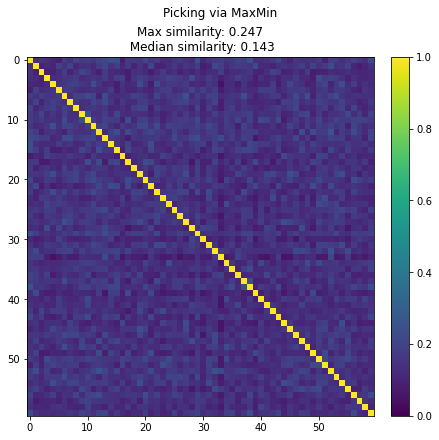

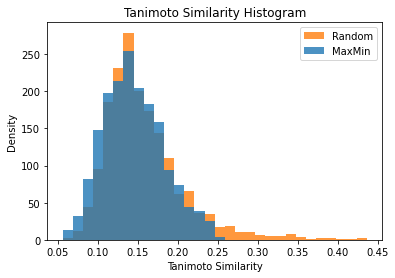

In [127]:
from rdkit.SimDivFilters import rdSimDivPickers
lp = rdSimDivPickers.LeaderPicker()

thresh = 0.75 # <- minimum distance between cluster centroids
picks = lp.LazyBitVectorPick(df['fps'].values, len(df), thresh, pickSize=60)
# print('Number of mols picked: {}'.format(len(picks)))

maxmin_mols = [df['mol'].values[x] for x in picks]
maxmin_fps = [df['fps'].values[x] for x in picks]

maxmin_mat = np.empty((len(maxmin_fps), len(maxmin_fps)))
for i in range(len(maxmin_fps)):
    maxmin_mat[i] = np.array(
        DataStructs.BulkTanimotoSimilarity(maxmin_fps[i], maxmin_fps))

fig, ax = plt.subplots(figsize=(6, 6), constrained_layout=True)
fig.suptitle('Picking via MaxMin')
cax = ax.matshow(maxmin_mat, aspect="auto", vmin=0, vmax=1)
ax.set_title('Max similarity: {:.3f}\n Median similarity: {:.3f}'.format(
    np.amax(maxmin_mat[~np.eye(maxmin_mat.shape[0], dtype=bool)]),
    np.median(maxmin_mat[~np.eye(maxmin_mat.shape[0], dtype=bool)])))
ax.xaxis.set_ticks_position('bottom')
fig.colorbar(cax)
plt.show()

fig = plt.figure()
mask = np.tri(maxmin_mat.shape[0], k=-1)  # masks the lower triangle
maxmin_masked = np.ma.array(maxmin_mat, mask=mask)
plt.title('Tanimoto Similarity Histogram')
_, bins, _ = plt.hist(rand_mat[rand_masked.mask].flatten(),
         bins=30, label='Random', alpha=0.8, color=cmap(1))  # only choose the lower triangle
plt.hist(maxmin_mat[maxmin_masked.mask].flatten(),
         bins=bins, label='MaxMin', alpha=0.8, color=cmap(0))  # only choose the lower triangle
plt.legend(loc='upper right')
plt.xlabel('Tanimoto Similarity')
plt.ylabel('Density')
plt.show()

display(HTML("<h3>MaxMin</h3>"))
mols2grid.display(maxmin_mols, template="table",
                  n_rows=15, n_cols=4, subset=["img"], tooltip=['SMILES'], maxMols=60, size=(300, 150))


In [15]:
from rdkit.DataManip.Metric import GetTanimotoDistMat
from rdkit.SimDivFilters.rdSimDivPickers import HierarchicalClusterPicker, ClusterMethod

ward = HierarchicalClusterPicker(ClusterMethod.WARD)
ids = ward.Pick(GetTanimotoDistMat(df['fps'].values), len(df['mol'].values), 60)

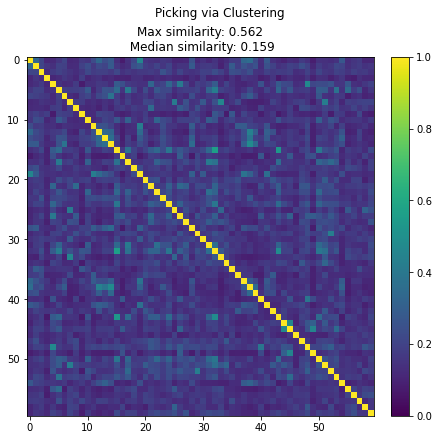

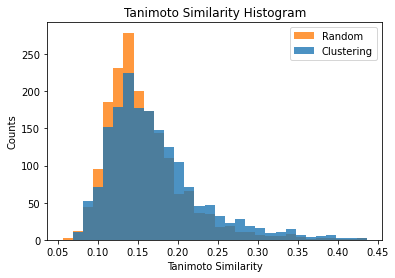

In [130]:
import mols2grid

ward_mols = [df['mol'].values[x] for x in ids]
ward_fps = [df['fps'].values[x] for x in ids]

ward_mat = np.empty((len(ward_fps), len(ward_fps)))
for i in range(len(ward_fps)):
    ward_mat[i] = np.array(
        DataStructs.BulkTanimotoSimilarity(ward_fps[i], ward_fps))

fig, ax = plt.subplots(figsize=(6, 6), constrained_layout=True)
fig.suptitle('Picking via Clustering')
cax = ax.matshow(ward_mat, aspect="auto", vmin=0, vmax=1)
ax.set_title('Max similarity: {:.3f}\n Median similarity: {:.3f}'.format(
    np.amax(ward_mat[~np.eye(ward_mat.shape[0], dtype=bool)]),
    np.median(ward_mat[~np.eye(ward_mat.shape[0], dtype=bool)])))
ax.xaxis.set_ticks_position('bottom')
fig.colorbar(cax)

fig = plt.figure()
mask = np.tri(ward_mat.shape[0], k=-1)  # masks the lower triangle
ward_masked = np.ma.array(ward_mat, mask=mask)
plt.title('Clustering')
plt.title('Tanimoto Similarity Histogram')
_, bins, _ = plt.hist(rand_mat[rand_masked.mask].flatten(),
                      bins=30, label='Random', alpha=0.8, color=cmap(1))  # only choose the lower triangle
plt.hist(ward_mat[ward_masked.mask].flatten(),
         bins=bins, label='Clustering', alpha=0.8, color=cmap(0))  # only choose the lower triangle
plt.legend(loc='upper right')
plt.xlabel('Tanimoto Similarity')
plt.ylabel('Counts')
plt.show()

display(HTML("<h3>Clustering</h3>"))
mols2grid.display([df['mol'].values[x] for x in ids], template="table",
                  n_rows=15, n_cols=4, subset=["img"], tooltip=['SMILES'], maxMols=60, size=(300, 150))


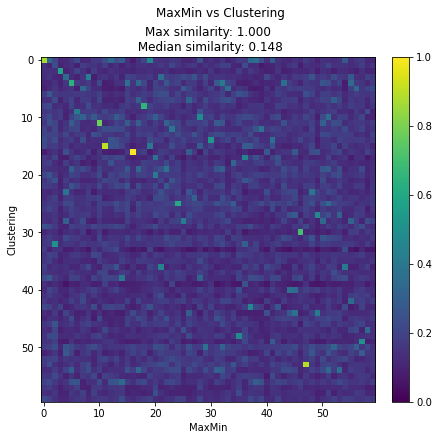

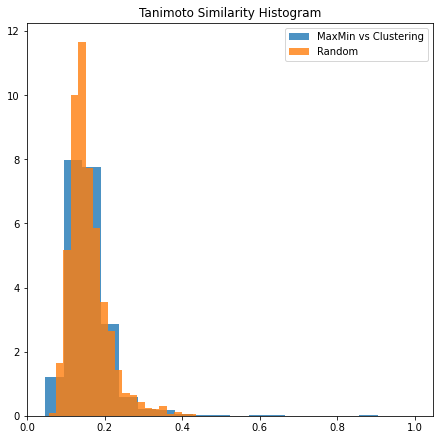

In [135]:
comp_mat = np.empty((len(maxmin_fps), len(ward_fps)))
for i in range(len(maxmin_fps)):
    comp_mat[i] = np.array(
        DataStructs.BulkTanimotoSimilarity(maxmin_fps[i], ward_fps))

fig, ax = plt.subplots(figsize=(6, 6), constrained_layout=True)
fig.suptitle('MaxMin vs Clustering')
cax = ax.matshow(comp_mat, aspect="auto", vmin=0, vmax=1)
ax.set_title('Max similarity: {:.3f}\n Median similarity: {:.3f}'.format(
    np.amax(comp_mat),
    np.median(comp_mat)))

ax.set_xlabel('MaxMin')
ax.set_ylabel('Clustering')
ax.xaxis.set_ticks_position('bottom')
fig.colorbar(cax)

fig, ax = plt.subplots(figsize=(6, 6), constrained_layout=True)
ax.set_title('Tanimoto Similarity Histogram')
ax.hist(comp_mat.flatten(),
        bins=20, density=True, label='MaxMin vs Clustering', alpha=0.8)  # only choose the lower triangle

ax.hist(rand_mat[rand_masked.mask].flatten(),
            bins=20, density=True, label='Random', alpha=0.8)  # only choose the lower triangle
plt.legend(loc='upper right')
plt.show()

top_n = len(comp_mat[comp_mat==1])

max_inds = np.unravel_index(np.argpartition(
    comp_mat.flatten(), -top_n)[-top_n:], shape=(comp_mat.shape))

x = max_inds[0]
y = max_inds[1]

mols2grid.display([ward_mols[i] for i in y],
                  size=(300, 150), subset=["img"], tooltip=['SMILES'], template='table')


In [13]:
data_dir = '/rds-d7/project/rds-ZNFRY9wKoeE/EnamineREAL/data/'

pd.DataFrame(smi, columns=['smiles']).to_csv(data_dir+'../topN/'+target+'_picks.csv', index=False)


NameError: name 'smi' is not defined

In [42]:
from collections import defaultdict
import numpy as np

def assignPointsToClusters(picks,fps):
    clusters = defaultdict(list)
    for i,idx in enumerate(picks):
        clusters[i].append(idx)
    sims = np.zeros((len(picks),len(fps)))
    for i in range(len(picks)):
        pick = picks[i]
        sims[i,:] = DataStructs.BulkTanimotoSimilarity(fps[pick],fps)
        sims[i,i] = 0
    best = np.argmax(sims,axis=0)
    for i,idx in enumerate(best):
        if i not in picks:
            clusters[idx].append(i)
    return clusters

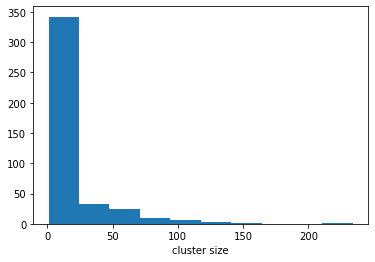

In [43]:
clusters = assignPointsToClusters(picks,fps)
hist([len(clusters[x]) for x in clusters]);
xlabel('cluster size');

In [44]:
clusts12 = [x for x in clusters if len(clusters[x])==16]
len(clusts12)

7

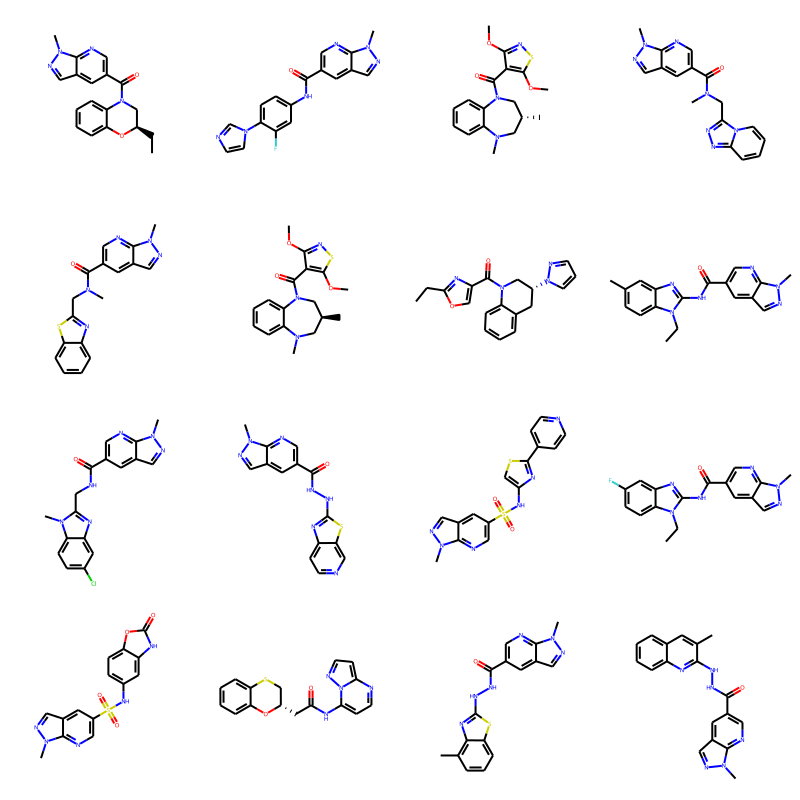

In [48]:
Draw.MolsToGridImage([ms[x] for x in clusters[clusts12[3]]],molsPerRow=4)


# Visualise Picks

In [46]:
def return_picks(target):
    data_dir = '/rds-d7/project/rds-ZNFRY9wKoeE/EnamineREAL/data/'

    df = pd.read_csv(data_dir+'../topN/topN_new_filtered_' + target+'.csv')
    print('No. of mols before alert filtering: {}'.format(len(df)))

    df['mol'] = [Chem.MolFromSmiles(smi) for smi in df["smiles"]]
    df["alerts"] = df['mol'].apply(search_alerts)

    df = df[~df["alerts"]].reset_index()
    print('No. of mols after alert filtering: {}'.format(len(df)))

    df['fps'] = [rdMolDescriptors.GetMorganFingerprintAsBitVect(
        m, 2, 2048) for m in df['mol']]

    lp = rdSimDivPickers.LeaderPicker()

    thresh = 0.75  # <- minimum distance between cluster centroids
    picks = lp.LazyBitVectorPick(df['fps'].values, len(df), thresh, pickSize=60)
    # print('Number of mols picked: {}'.format(len(picks)))

    picked_df = df.iloc[picks]

    return picked_df

mpro_picks = return_picks('mpro')
mac1_picks = return_picks('mac1')
dpp11_picks = return_picks('dpp11')

No. of mols before alert filtering: 30902
No. of mols after alert filtering: 25184
No. of mols before alert filtering: 50000
No. of mols after alert filtering: 46666
No. of mols before alert filtering: 50000
No. of mols after alert filtering: 43763


In [53]:
print(mpro_picks['fps'].values[1])

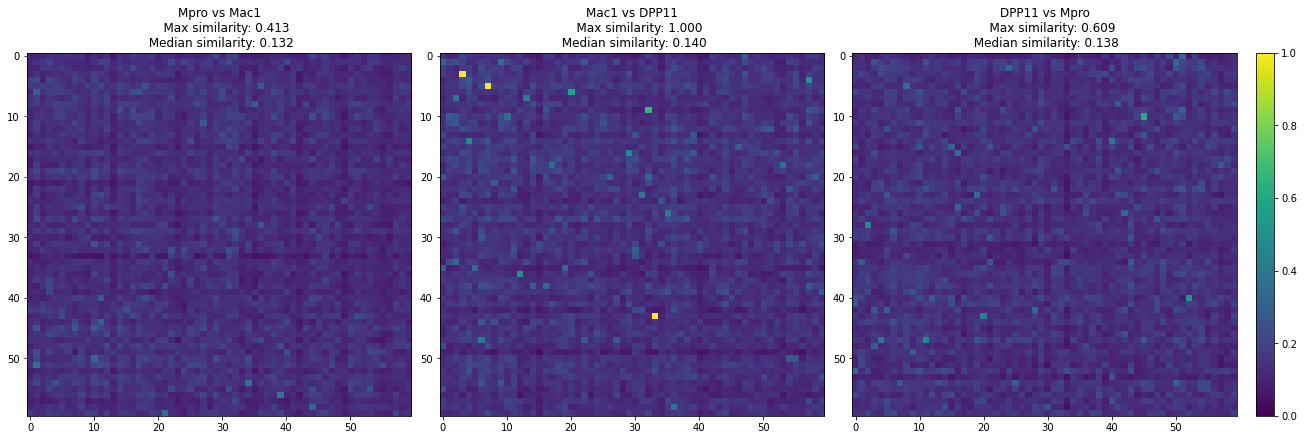

In [67]:
mpro_vs_mac1 = np.empty((len(mpro_picks['fps']), len(mac1_picks['fps'])))
for i in range(len(mpro_picks['fps'])):
    mpro_vs_mac1[i] = np.array(
        DataStructs.BulkTanimotoSimilarity(mpro_picks['fps'].values[i], mac1_picks['fps'].values))

mac1_vs_dpp11 = np.empty((len(mac1_picks['fps']), len(dpp11_picks['fps'])))
for i in range(len(mac1_picks['fps'])):
    mac1_vs_dpp11[i] = np.array(
        DataStructs.BulkTanimotoSimilarity(mac1_picks['fps'].values[i], dpp11_picks['fps'].values))

dpp11_vs_mpro = np.empty((len(dpp11_picks['fps']), len(mpro_picks['fps'])))
for i in range(len(dpp11_picks['fps'])):
    dpp11_vs_mpro[i] = np.array(
        DataStructs.BulkTanimotoSimilarity(dpp11_picks['fps'].values[i], mpro_picks['fps'].values))

fig, axs = plt.subplots(figsize=(18, 6), nrows=1, ncols=3, constrained_layout=True)
# fig.suptitle('Comparing picked molecules')
cax = axs[0].matshow(mpro_vs_mac1, aspect="auto", vmin=0, vmax=1)
axs[0].set_title('Mpro vs Mac1\n\
    Max similarity: {:.3f}\n Median similarity: {:.3f}'.format(
    np.amax(mpro_vs_mac1),
    np.median(mpro_vs_mac1)))
axs[0].xaxis.set_ticks_position('bottom')
# fig.colorbar(cax)

cax = axs[1].matshow(mac1_vs_dpp11, aspect="auto", vmin=0, vmax=1)
axs[1].set_title('Mac1 vs DPP11\n\
    Max similarity: {:.3f}\n Median similarity: {:.3f}'.format(
    np.amax(mac1_vs_dpp11),
    np.median(mac1_vs_dpp11)))
axs[1].xaxis.set_ticks_position('bottom')
# fig.colorbar(cax)

cax = axs[2].matshow(dpp11_vs_mpro, aspect="auto", vmin=0, vmax=1)
axs[2].set_title('DPP11 vs Mpro\n\
    Max similarity: {:.3f}\n Median similarity: {:.3f}'.format(
    np.amax(dpp11_vs_mpro),
    np.median(dpp11_vs_mpro)))
axs[2].xaxis.set_ticks_position('bottom')
fig.colorbar(cax)


In [92]:
top_n = 3

max_inds = np.unravel_index(np.argpartition(
    mac1_vs_dpp11.flatten(), -top_n)[-top_n:], shape=((len(mac1_picks['fps']), len(dpp11_picks['fps']))))

x = max_inds[0]
y = max_inds[1]

mols2grid.display([Chem.MolFromSmiles(x) for x in dpp11_picks['smiles'].iloc[y]],
                  size=(300, 150), subset=["img"], tooltip=['SMILES'], template='table')

# for n in range(top_n):
    
#     print(dpp11_picks.iloc[y[n]]['smiles'], mac1_picks.iloc[x[n]]['smiles'])
#     assert dpp11_picks.iloc[y[n]]['smiles'] == mac1_picks.iloc[x[n]]['smiles']
